In [270]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [271]:
import sys
from pathlib import Path

sys.path.append(str(Path().cwd().parent))

In [272]:
import model
import load_dataset
from plotting import plot_ts

### Возьмем временной ряд

In [273]:
dataset = load_dataset.Dataset('../data/dataset/')

In [274]:
ts = dataset['daily-min-temperatures.csv']

In [275]:
ts.head()

1981-01-01
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
1981-01-06    15.8
Name: 20.7, dtype: float64

<AxesSubplot:xlabel='1981-01-01'>

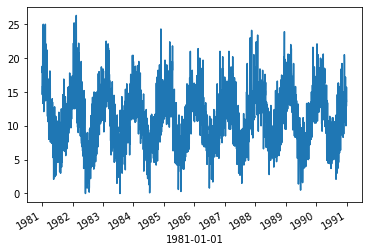

In [276]:
ts.plot()

###  Зададим гранулярность

In [277]:
# гранулярность, она же частота временного ряда, задается в согласии с форматов iso6801
# https://en.wikipedia.org/wiki/ISO_8601
granularity = 'P1D'

In [278]:
import isodate
isodate.parse_duration(granularity)

datetime.timedelta(days=1)

### Зададим ширину окна

In [279]:
num_lags = 365

### Зададим модель

In [280]:
from sklearn.linear_model import LinearRegression
Model = LinearRegression

### Создадим экзэмпляр класса TimeSeriesPredictor

In [281]:
predictor = model.TimeSeriesPredictor(
    granularity=granularity,
    num_lags=num_lags,
    Model=Model
)

### Посмотрим, как работает метод transform_into_matrix

In [282]:
lags_matrix = predictor.transform_into_matrix(ts)

In [283]:
lags_matrix

,lag_365,lag_364,lag_363,lag_362,lag_361,lag_360,lag_359,lag_358,lag_357,lag_356,...,lag_9,lag_8,lag_7,lag_6,lag_5,lag_4,lag_3,lag_2,lag_1,lag_0
1981-01-01,,,,,,,,,,,,,,,,,,,,,
1982-01-02,17.9,18.8,14.6,15.8,15.8,15.8,17.4,21.8,20.0,16.2,...,15.0,14.2,14.0,15.5,13.3,15.6,15.2,17.4,17.0,15.0
1982-01-03,18.8,14.6,15.8,15.8,15.8,17.4,21.8,20.0,16.2,13.3,...,14.2,14.0,15.5,13.3,15.6,15.2,17.4,17.0,15.0,13.5
1982-01-04,14.6,15.8,15.8,15.8,17.4,21.8,20.0,16.2,13.3,16.7,...,14.0,15.5,13.3,15.6,15.2,17.4,17.0,15.0,13.5,15.2
1982-01-05,15.8,15.8,15.8,17.4,21.8,20.0,16.2,13.3,16.7,21.5,...,15.5,13.3,15.6,15.2,17.4,17.0,15.0,13.5,15.2,13.0
1982-01-06,15.8,15.8,17.4,21.8,20.0,16.2,13.3,16.7,21.5,25.0,...,13.3,15.6,15.2,17.4,17.0,15.0,13.5,15.2,13.0,12.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1990-12-27,13.3,11.7,10.4,14.4,12.7,14.8,13.3,15.6,14.5,14.3,...,17.2,14.7,15.4,13.1,13.2,13.9,10.0,12.9,14.6,14.0
1990-12-28,11.7,10.4,14.4,12.7,14.8,13.3,15.6,14.5,14.3,15.3,...,14.7,15.4,13.1,13.2,13.9,10.0,12.9,14.6,14.0,13.6
1990-12-29,10.4,14.4,12.7,14.8,13.3,15.6,14.5,14.3,15.3,16.4,...,15.4,13.1,13.2,13.9,10.0,12.9,14.6,14.0,13.6,13.5


### Обучим модель

In [284]:
predictor.fit(ts)

### Предскажем следующие несколько точек

In [288]:
prediction = predictor.predict_next(ts, n_steps=365)

In [289]:
prediction

1991-01-01    14.425141
1991-01-02    13.961915
1991-01-03    14.250580
1991-01-04    15.415840
1991-01-05    15.498529
                ...    
1991-12-27    14.552094
1991-12-28    13.845009
1991-12-29    14.171889
1991-12-30    14.510172
1991-12-31    14.085806
Length: 365, dtype: float64

In [290]:
plot_ts(ts, prediction)

Loading BokehJS ...

### Зададим сторонние признаки

In [291]:
import math


def get_hour(timestamp):
    """Gets hour from timestamp"""
    hour = timestamp.hour
    theta = 2 * math.pi * hour
    return math.sin(theta)

def get_monthdate(timestamp):
    day = timestamp.day
    theta = 2 * math.pi * day
    return math.sin(theta)

def get_month(timestamp):
    month = timestamp.month
    theta = 2 * math.pi * month
    return math.sin(theta)

def get_dayofweek(timestamp):
    dayofweek = timestamp.dayofweek
    theta = 2 * math.pi * dayofweek
    return math.sin(theta)


external_features = {
    'hour': get_hour,
    'monthdate': get_monthdate,
    'month': get_month,
    'dayofweek': get_dayofweek,
}

### Добавим сторонние признаки

In [292]:
feature_matrix = predictor.enrich(lags_matrix)

In [293]:
feature_matrix

,lag_365,lag_364,lag_363,lag_362,lag_361,lag_360,lag_359,lag_358,lag_357,lag_356,...,lag_9,lag_8,lag_7,lag_6,lag_5,lag_4,lag_3,lag_2,lag_1,lag_0
1981-01-01,,,,,,,,,,,,,,,,,,,,,
1982-01-02,17.9,18.8,14.6,15.8,15.8,15.8,17.4,21.8,20.0,16.2,...,15.0,14.2,14.0,15.5,13.3,15.6,15.2,17.4,17.0,15.0
1982-01-03,18.8,14.6,15.8,15.8,15.8,17.4,21.8,20.0,16.2,13.3,...,14.2,14.0,15.5,13.3,15.6,15.2,17.4,17.0,15.0,13.5
1982-01-04,14.6,15.8,15.8,15.8,17.4,21.8,20.0,16.2,13.3,16.7,...,14.0,15.5,13.3,15.6,15.2,17.4,17.0,15.0,13.5,15.2
1982-01-05,15.8,15.8,15.8,17.4,21.8,20.0,16.2,13.3,16.7,21.5,...,15.5,13.3,15.6,15.2,17.4,17.0,15.0,13.5,15.2,13.0
1982-01-06,15.8,15.8,17.4,21.8,20.0,16.2,13.3,16.7,21.5,25.0,...,13.3,15.6,15.2,17.4,17.0,15.0,13.5,15.2,13.0,12.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1990-12-27,13.3,11.7,10.4,14.4,12.7,14.8,13.3,15.6,14.5,14.3,...,17.2,14.7,15.4,13.1,13.2,13.9,10.0,12.9,14.6,14.0
1990-12-28,11.7,10.4,14.4,12.7,14.8,13.3,15.6,14.5,14.3,15.3,...,14.7,15.4,13.1,13.2,13.9,10.0,12.9,14.6,14.0,13.6
1990-12-29,10.4,14.4,12.7,14.8,13.3,15.6,14.5,14.3,15.3,16.4,...,15.4,13.1,13.2,13.9,10.0,12.9,14.6,14.0,13.6,13.5


In [294]:
predictor.fit(ts)

In [295]:
prediction = predictor.predict_next(ts, n_steps=365)

In [296]:
plot_ts(ts, prediction)

Loading BokehJS ...

#### Trying to beat arima in alcohol sales predictions

In [319]:
from sklearn.linear_model import Ridge

In [320]:
ts = dataset['alcohol_sales.csv']

In [321]:
ts_train, ts_test = ts[:270], ts[270:]

In [322]:
Model = Ridge

In [323]:
predictor = model.TimeSeriesPredictor(
    granularity='P31D',
    num_lags=24,
    Model=Model,
)

In [324]:
predictor.fit(ts_train)

In [325]:
predict = predictor.predict_next(ts_train, n_steps=len(ts_test))

In [326]:
plot_ts(ts, predict)

Loading BokehJS ...

In [327]:
param_grid = {
    'num_lags': [12, 24, 36],
    'alpha': [0, 1, 3, 10],
    'normalize': [True, False]
}

In [328]:
from itertools import product

In [329]:
from sklearn.metrics import mean_squared_error

In [330]:
scores = {}

for n_lags, alpha, normalize in product(*list(param_grid.values())):
    
    predictor = model.TimeSeriesPredictor(
        granularity='P31D', Model=Model, num_lags=n_lags, alpha=alpha, normalize=normalize)
    
    predictor.fit(ts_train)
    predicted = predictor.predict_next(ts_train, n_steps=len(ts_test))
    error = mean_squared_error(ts_test, predicted)
    scores[(n_lags, alpha, normalize)] = error
    print(n_lags, alpha, normalize, error)

12 0 True 246633282.94023103
12 0 False 246633282.94022828
12 1 True 4278975.812375333
12 1 False 246633262.6366048
12 3 True 11558690.429089218
12 3 False 246633222.02936938
12 10 True 19775038.103039425
12 10 False 246633079.90407726
24 0 True 5138468.165801165
24 0 False 5138468.165800595
24 1 True 1990538.705378566
24 1 False 5138467.495771469
24 3 True 3565061.721511872
24 3 False 5138466.155713194
24 10 True 10012321.963513346
24 10 False 5138461.465513788
36 0 True 6139977.082066335
36 0 False 6139977.0820672065
36 1 True 1954280.0979845254
36 1 False 6139976.866387585
36 3 True 2321278.747381948
36 3 False 6139976.435028421
36 10 True 5374578.651774814
36 10 False 6139974.925270887


In [331]:
best_params = sorted(scores.items(), key=lambda x: x[1], )[0][0]

In [332]:
best_params

(36, 1, True)

In [333]:
num_lags, alpha, normalize = best_params

In [334]:
predictor = model.TimeSeriesPredictor(
    granularity='P31D',
    num_lags=num_lags,
    Model=Model,
    alpha=alpha,
    normalize=normalize
)

In [335]:
predictor.fit(ts_train)

In [336]:
predict = predictor.predict_next(ts_train, n_steps=len(ts_test))

In [337]:
plot_ts(ts, predict)

Loading BokehJS ...